In [51]:
import pandas as pd
from itertools import combinations
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
from fa2_modified import ForceAtlas2
import numpy as np
import pickle as pkl
from textblob import TextBlob

# Load the dataset
df = pd.read_csv('data/avatar.csv', encoding='ISO-8859-1')

# Initialize a dictionary to store character connections
character_connections = {}

scene_characters = set()  # Characters in the current scene

# Name replacements for normalization
name_replacements = {
    'young zuko': 'zuko',
    'young azula': 'azula',
    'young katara': 'katara',
    'young sokka': 'sokka',
    'young toph': 'toph',
    'young aang': 'aang',
    'king bumi': 'bumi',
    'avatar roku': 'roku',
    'avatar kyoshi': 'kyoshi',
    'avatar kuruk': 'kuruk',
    'avatar yangchen': 'yangchen',
    'aang:': 'aang',
    'sha-mo:': 'sha-mo',    
}

# Exclude these words from being counted as characters
invalid_characters = {'together', 'both'}

# Function to normalize character names
def normalize_name(name):
    # Convert to lowercase, strip spaces, and standardize
    normalized = name.lower().strip()
    return name_replacements.get(normalized, normalized)

# Function to split multiple characters and normalize their names
def split_characters(character):
    # Replace "Team Avatar" with its members
    if 'team avatar' in character.lower():
        return ['sokka', 'katara', 'aang', 'toph']
    
    # Use regex to split by commas or 'and', and normalize each name
    names = [normalize_name(name) for name in re.split(r',|\band\b', character)]
    # Filter out invalid characters
    return [name for name in names if name not in invalid_characters]

# Iterate over each row to detect scene boundaries
for _, row in df.iterrows():
    # Check if the row indicates a new scene
    if row['character'] == 'Scene Description':
        # Create character pairs for the completed scene
        pairs = combinations(scene_characters, 2)
        for pair in pairs:
            pair = tuple(sorted(pair))  # Ensure consistent ordering
            if pair in character_connections:
                character_connections[pair] += 1
            else:
                character_connections[pair] = 1

        # Reset the scene_characters for the next scene
        scene_characters = set()
    else:
        # Check for multiple characters and add each to the current scene
        characters = split_characters(row['character'])
        scene_characters.update(characters)

# Convert to DataFrame for analysis
connections_df = pd.DataFrame(list(character_connections.items()), columns=['pair', 'count'])

# Display the connections
print(connections_df)

# Save the DataFrame to a CSV file
connections_df.to_csv('character_connections.csv', index=False)


                pair  count
0    (katara, sokka)    386
1       (iroh, zuko)    112
2     (aang, katara)    411
3      (aang, sokka)    409
4      (aang, kanna)      3
..               ...    ...
963    (iroh, pakku)      1
964     (bumi, iroh)      1
965     (ozai, suki)      1
966      (iroh, mai)      1
967      (mai, toph)      1

[968 rows x 2 columns]


In [52]:
# Load the dataset
df = pd.read_csv('data/avatar.csv', encoding='ISO-8859-1')

# Prepare the attributes dictionary
character_attributes = {}

# Sentiment Analysis Function
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity if pd.notna(text) else 0

# Iterate through each row
for _, row in df.iterrows():
    if row['character'] == 'Scene Description':  # New scene boundary
        # Increment scene counts for all characters in the scene
        for character in scene_characters:
            if character in character_attributes:
                character_attributes[character]['scene_count'] += 1
        scene_characters = set()  # Reset for the next scene
    else:
        # Track characters in the current scene
        characters = split_characters(row['character'])
        scene_characters.update(characters)

        for character in characters:
            if character not in character_attributes:
                character_attributes[character] = {
                    'dialogue_count': 0,
                    'scene_count': 0,
                    'episode_count': set(),
                    'arc_presence': set(),
                    'sentiment_sum': 0,
                    'sentiment_count': 0
                }

            # Increment dialogue count by the number of words in the dialogue
            dialogue = row['character_words']
            word_count = len(dialogue.split()) if pd.notna(dialogue) else 0
            character_attributes[character]['dialogue_count'] += word_count

            # Track episodes and arcs
            character_attributes[character]['episode_count'].add((row['book'], row['chapter']))
            character_attributes[character]['arc_presence'].add(row['book'])

            # Update sentiment analysis
            sentiment = calculate_sentiment(dialogue)
            character_attributes[character]['sentiment_sum'] += sentiment
            character_attributes[character]['sentiment_count'] += 1

# Process the attributes into a DataFrame
processed_attributes = []
for character, attributes in character_attributes.items():
    processed_attributes.append({
        'character': character,
        'dialogue_count': attributes['dialogue_count'],
        'scene_count': attributes['scene_count'],
        'episode_count': len(attributes['episode_count']),
        'arc_presence': ', '.join(attributes['arc_presence']),
        'average_sentiment': (attributes['sentiment_sum'] / attributes['sentiment_count']) if attributes['sentiment_count'] > 0 else None
    })

character_df = pd.DataFrame(processed_attributes)

# Save to CSV
character_df.to_csv('character_attributes.csv', index=False)

# Display the DataFrame
print(character_df)


            character  dialogue_count  scene_count  episode_count  \
0              katara           15067          875             59   
1               sokka           18392         1009             59   
2                zuko            9277          466             47   
3                iroh            5276          198             36   
4                aang           17947         1120             60   
..                ...             ...          ...            ...   
345          yangchen              90            1              1   
346       lion turtle              78            4              2   
347  banished servant              33            1              1   
348    head of dai li              28            1              1   
349           qin lee              10            1              1   

           arc_presence  average_sentiment  
0    Fire, Earth, Water           0.059311  
1    Fire, Earth, Water           0.058501  
2    Fire, Earth, Water           0.

In [53]:
# Load the character attributes data
character_data = pd.read_csv('character_attributes.csv')

# Load the connections data
connections_data = pd.read_csv('character_connections.csv')

# Create a graph object
G = nx.Graph()

# Add nodes to the graph with character attributes
for index, row in character_data.iterrows():
    G.add_node(row['character'], dialogue_count=row['dialogue_count'],
                                scene_count=row['scene_count'], 
                                arc_presence=row['arc_presence'],
                                average_sentiment=row['average_sentiment'])

# Add edges to the graph with the count as weight
for index, row in connections_data.iterrows():
    pair = eval(row['pair'])  # Convert the string tuple to an actual tuple
    count = row['count']
    G.add_edge(pair[0], pair[1], weight=count)


In [49]:

# Extract the largest connected component
largest_component = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

# Save the graph as a .pkl file
with open('largest_component_graph.pkl', 'wb') as file:
    pkl.dump(G_largest, file)

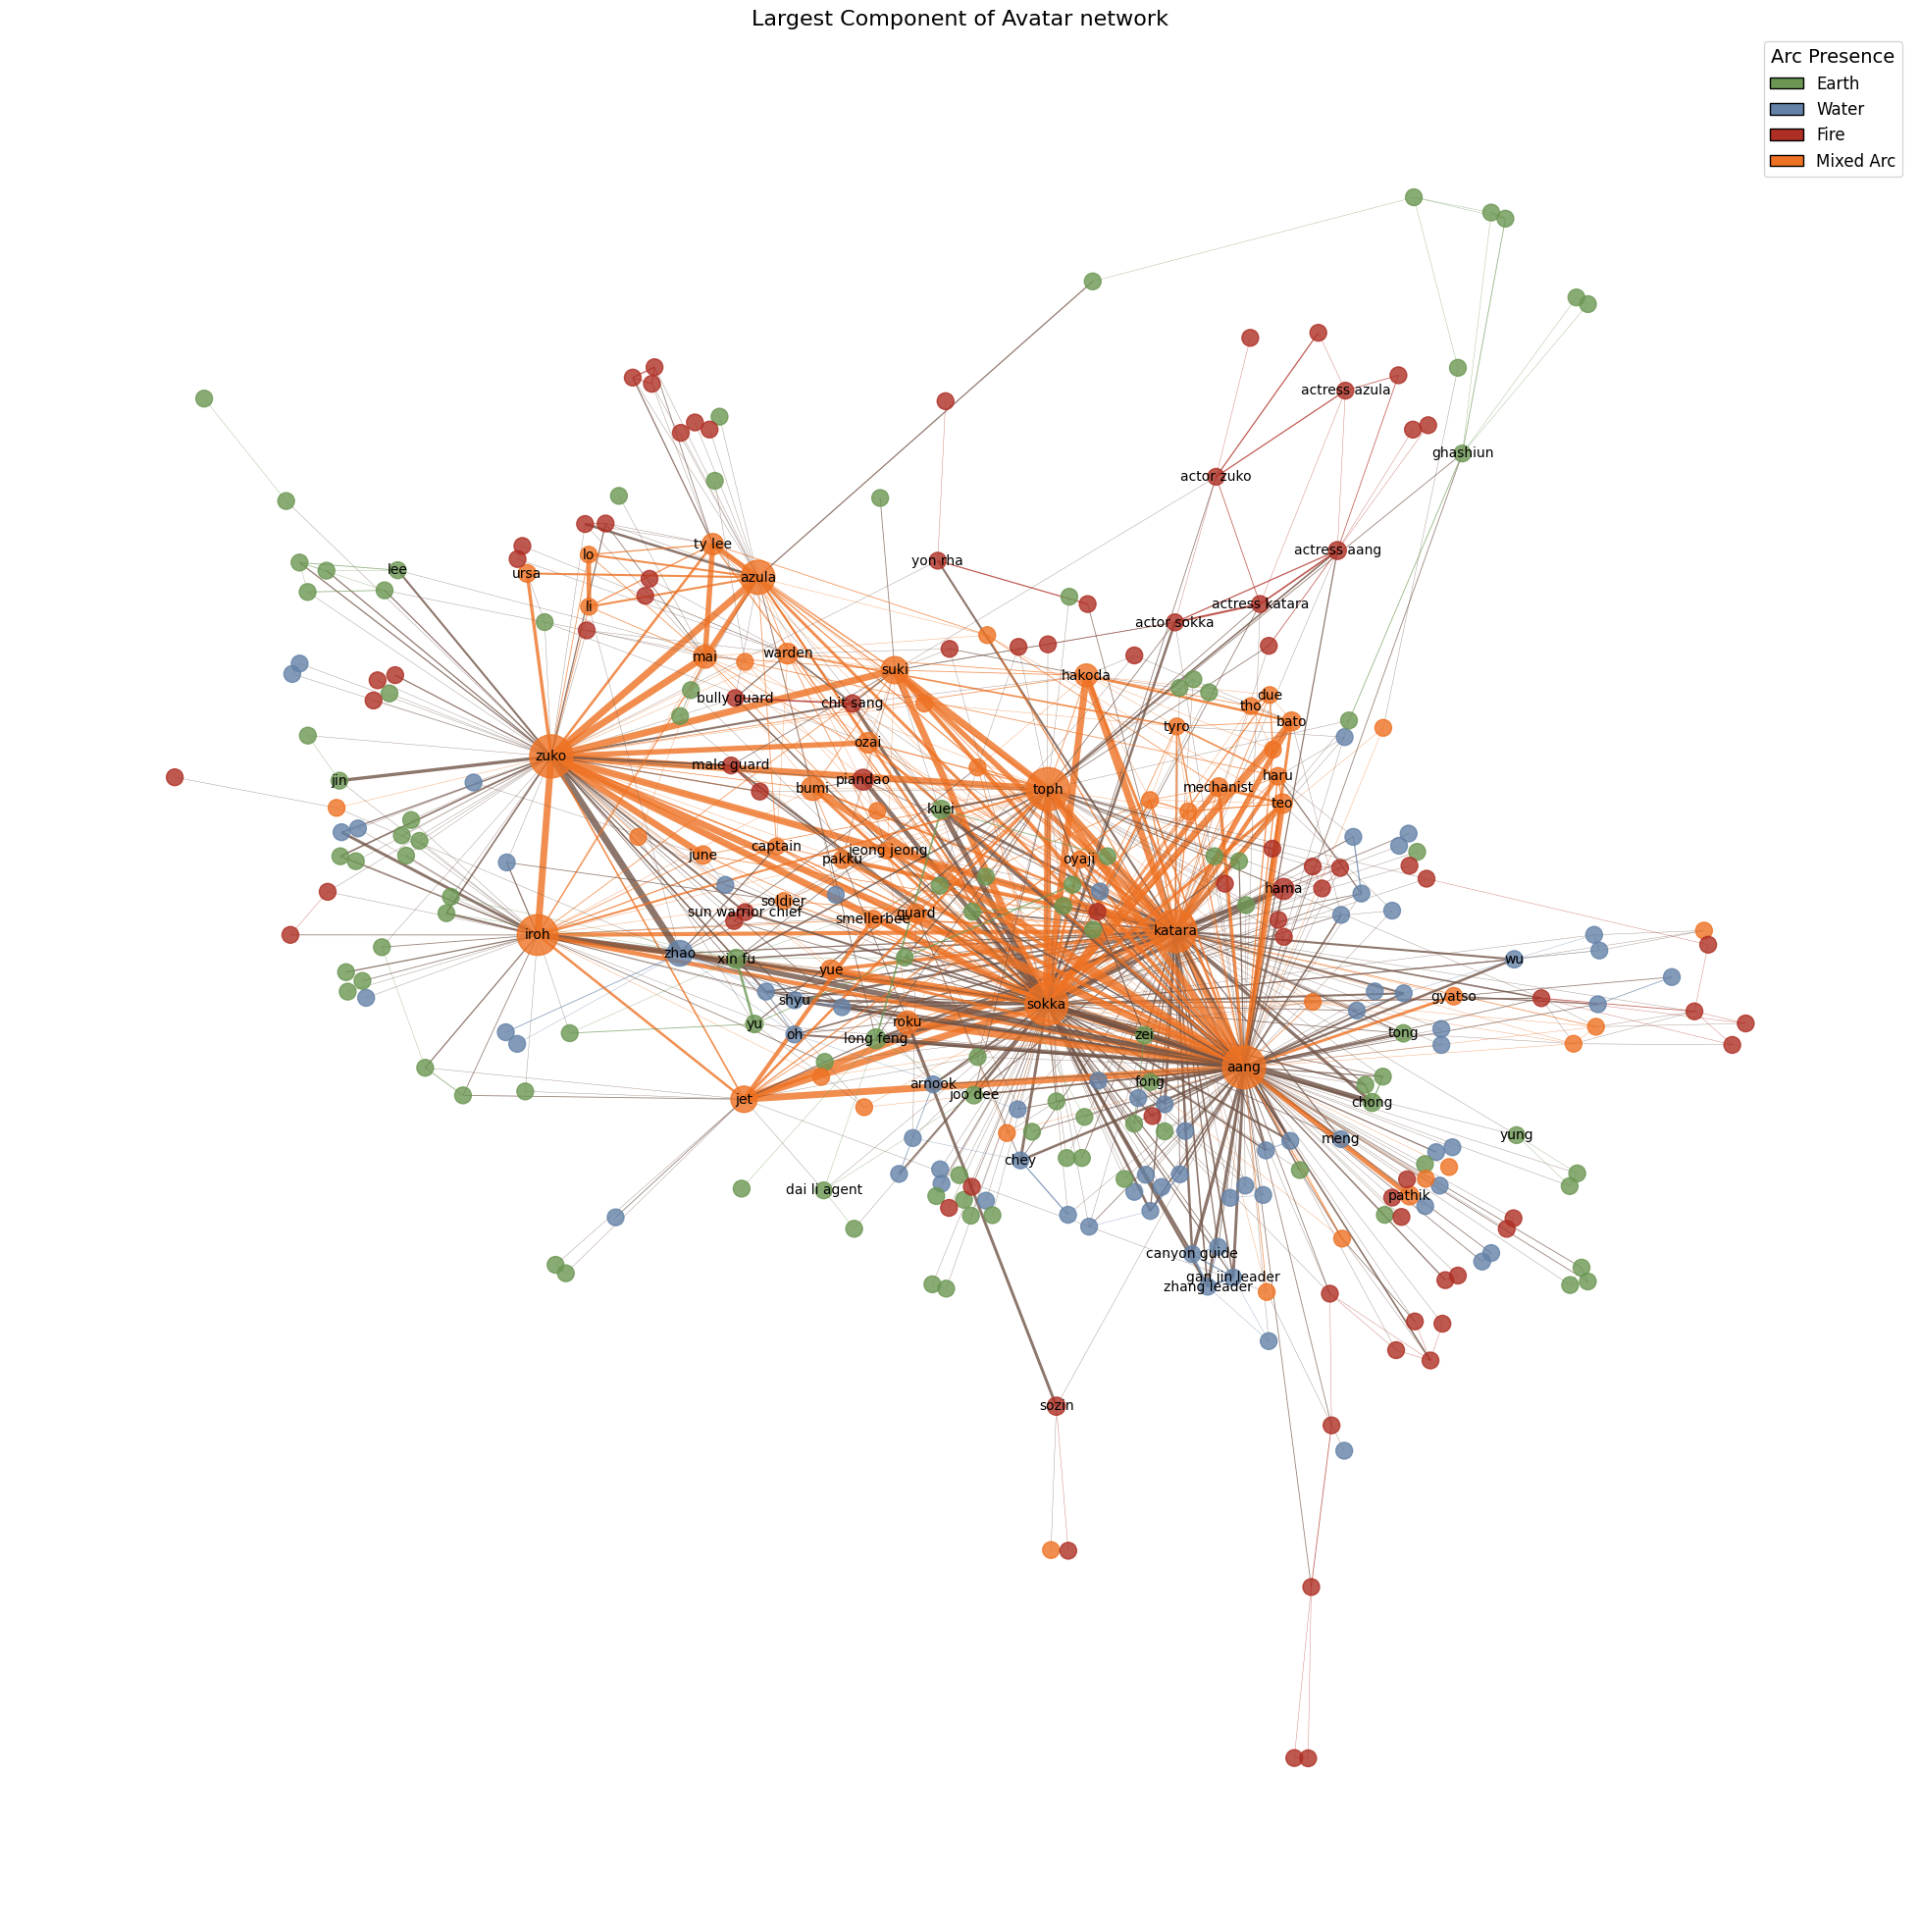

In [50]:
# Initialize ForceAtlas2 for layout generation
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    adjustSizes=False,
    edgeWeightInfluence=1,
    jitterTolerance=1,
    barnesHutOptimize=True,
    barnesHutTheta=0,
    multiThreaded=False,
    scalingRatio=0.000001,
    strongGravityMode=False,
    gravity=0.0001,
    verbose=False
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G_largest, pos=None, iterations=1000)


# Define a function to determine node colors based on arc presence
def get_node_color(arc_presence):
    earth_color = "#6C9753"  # Green
    water_color = "#6482A8"  # Blue
    fire_color = "#AE2F24"   # Red
    mixed_color = "#EE7223"  # Orange
    default_color = "#715447"  

    colors = []
    if "earth" in arc_presence.lower():
        colors.append(earth_color)
    if "water" in arc_presence.lower():
        colors.append(water_color)
    if "fire" in arc_presence.lower():
        colors.append(fire_color)
    if len(colors) == 1:
        return colors[0]
    elif len(colors) > 1:
        return mixed_color  # Use mixed color for multiple arcs
    return default_color  # Default color for no arcs

# Get node sizes and colors
node_sizes = []
node_colors = []

for node in G_largest.nodes(data=True):
    attributes = node[1]
    scene_count = attributes.get("scene_count", 0)
    arc_presence = attributes.get("arc_presence", "")

    # Scale node size with a base size and proportional factor
    scaled_size = 100 + (scene_count / 50) * 200  # Increase base size and scaling factor
    scaled_size = max(150, scaled_size)  # Ensure a larger minimum size
    scaled_size = min(1000, scaled_size)  # Cap the maximum size at a higher value
    node_sizes.append(scaled_size)

    # Node color is based on arc presence
    node_colors.append(get_node_color(arc_presence))

# Define a function to determine edge colors based on connected nodes
def get_edge_color(u, v):
    u_color = get_node_color(G_largest.nodes[u].get("arc_presence", ""))
    v_color = get_node_color(G_largest.nodes[v].get("arc_presence", ""))
    if u_color == v_color:
        return u_color
    return "#715447"  

# Define a scaling factor and cap for edge widths
scaling_factor = 0.3  # Adjust this to make edges thinner
max_width = 5  # Set a maximum width for edges
edge_widths = [
    min(G_largest[u][v].get('weight', 1) * scaling_factor, max_width) 
    for u, v in G_largest.edges()
]

# Get edge colors
edge_colors = [get_edge_color(u, v) for u, v in G_largest.edges()]

# Create legend elements
legend_elements = [
    Patch(facecolor="#6C9753", edgecolor="black", label="Earth"),
    Patch(facecolor="#6482A8", edgecolor="black", label="Water"),
    Patch(facecolor="#AE2F24", edgecolor="black", label="Fire"),
    Patch(facecolor="#EE7223", edgecolor="black", label="Mixed Arc")
]

# Visualize the network
plt.figure(figsize=(25, 25))

# Draw nodes
nx.draw_networkx_nodes(
    G_largest, positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.8
)

nx.draw_networkx_edges(
    G_largest, positions, 
    edge_color=edge_colors, 
    alpha=[min(0.6 + width / max_width, 0.8) for width in edge_widths], 
    width=edge_widths
)


import numpy as np
# Set the percentage for top nodes
percentage = 25  # Change this value to the desired percentage (e.g., 10, 20, etc.)

# Calculate the threshold for the top X% `scene_count`
scene_counts = [attr["scene_count"] for _, attr in G_largest.nodes(data=True)]
threshold = np.percentile(scene_counts, 100 - percentage)

# Identify key nodes
key_nodes = [node for node, attr in G_largest.nodes(data=True) if attr["scene_count"] > threshold]

# Draw labels only for key nodes
nx.draw_networkx_labels(
    G_largest, positions, 
    labels={node: node for node in key_nodes}, 
    font_size=10, 
    font_color="black"
)


# Add legend
plt.legend(handles=legend_elements, loc="upper right", fontsize=12, title="Arc Presence", title_fontsize=14)

plt.title("Largest Component of Avatar network", fontsize=16)
plt.axis("off")
plt.show()
